In [1]:
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp


tf.config.set_visible_devices([], 'GPU')


In [2]:
import pandas as pd
import sonnet as snt

from filterflow.smc import SMC
from filterflow.base import State, StateWithMemory, StateSeries, DTYPE_TO_STATE_SERIES

from filterflow.observation.base import ObservationModelBase, ObservationSampler
from filterflow.observation.linear import LinearObservationSampler
from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.transition.base import TransitionModelBase

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform, PartiallyCorrectedRegularizedTransform

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

## Load Data

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pickle

import numpy as np
from scipy.sparse import coo_matrix
data_dir = "../../data/piano_data"

def sparse_pianoroll_to_dense(pianoroll, min_note, num_notes):
    """Converts a sparse pianoroll to a dense numpy array.
    Given a sparse pianoroll, converts it to a dense numpy array of shape
    [num_timesteps, num_notes] where entry i,j is 1.0 if note j is active on
    timestep i and 0.0 otherwise.
    Args:
    pianoroll: A sparse pianoroll object, a list of tuples where the i'th tuple
      contains the indices of the notes active at timestep i.
    min_note: The minimum note in the pianoroll, subtracted from all notes so
      that the minimum note becomes 0.
    num_notes: The number of possible different note indices, determines the
      second dimension of the resulting dense array.
    Returns:
    dense_pianoroll: A [num_timesteps, num_notes] numpy array of floats.
    num_timesteps: A python int, the number of timesteps in the pianoroll.
    """
    num_timesteps = len(pianoroll)
    inds = []
    for time, chord in enumerate(pianoroll):
        # Re-index the notes to start from min_note.
        inds.extend((time, note-min_note) for note in chord)
        shape = [num_timesteps, num_notes]
    values = [1.] * len(inds)
    sparse_pianoroll = coo_matrix(
      (values, ([x[0] for x in inds], [x[1] for x in inds])),
      shape=shape)
    return sparse_pianoroll.toarray(), num_timesteps

def create_pianoroll_dataset(path,
                             split,
                             batch_size,
                             num_parallel_calls=4,
                             shuffle=False,
                             repeat=False,
                             min_note=21,
                             max_note=108):
    """Creates a pianoroll dataset.
    Args:
    path: The path of a pickle file containing the dataset to load.
    split: The split to use, can be train, test, or valid.
    batch_size: The batch size. If repeat is False then it is not guaranteed
      that the true batch size will match for all batches since batch_size
      may not necessarily evenly divide the number of elements.
    num_parallel_calls: The number of threads to use for parallel processing of
      the data.
    shuffle: If true, shuffles the order of the dataset.
    repeat: If true, repeats the dataset endlessly.
    min_note: The minimum note number of the dataset. For all pianoroll datasets
      the minimum note is number 21, and changing this affects the dimension of
      the data. This is useful mostly for testing.
    max_note: The maximum note number of the dataset. For all pianoroll datasets
      the maximum note is number 108, and changing this affects the dimension of
      the data. This is useful mostly for testing.
    Returns:
    inputs: A batch of input sequences represented as a dense Tensor of shape
      [time, batch_size, data_dimension]. The sequences in inputs are the
      sequences in targets shifted one timestep into the future, padded with
      zeros. This tensor is mean-centered, with the mean taken from the pickle
      file key 'train_mean'.
    targets: A batch of target sequences represented as a dense Tensor of
      shape [time, batch_size, data_dimension].
    lens: An int Tensor of shape [batch_size] representing the lengths of each
      sequence in the batch.
    mean: A float Tensor of shape [data_dimension] containing the mean loaded
      from the pickle file.
    """
    # Load the data from disk.
    num_notes = max_note - min_note + 1
    with tf.io.gfile.GFile(path, "rb") as f:
        raw_data = pickle.load(f)
    pianorolls = raw_data[split]
    mean = raw_data["train_mean"]
    num_examples = len(pianorolls)

    def pianoroll_generator():
        for sparse_pianoroll in pianorolls:
            yield sparse_pianoroll_to_dense(sparse_pianoroll, min_note, num_notes)

    dataset = tf.data.Dataset.from_generator(
      pianoroll_generator,
      output_types=(tf.float64, tf.int64),
      output_shapes=([None, num_notes], []))

    if repeat: 
        dataset = dataset.repeat()
    if shuffle: 
        dataset = dataset.shuffle(num_examples)

    # Batch sequences togther, padding them to a common length in time.
    dataset = dataset.padded_batch(batch_size,
                                 padded_shapes=([None, num_notes], []))

    def process_pianoroll_batch(data, lengths):
        """Create mean-centered and time-major next-step prediction Tensors."""
        data = tf.cast(tf.transpose(data, perm=[1, 0, 2]), float)
        lengths = tf.cast(lengths, tf.int32)
        targets = data
        # Mean center the inputs.
        inputs = data - tf.constant(mean, dtype=tf.float32,
                                    shape=[1, 1, mean.shape[0]])
        # Shift the inputs one step forward in time. Also remove the last timestep
        # so that targets and inputs are the same length.
        inputs = tf.pad(inputs, [[1, 0], [0, 0], [0, 0]], mode="CONSTANT")[:-1]
        # Mask out unused timesteps.
        inputs *= tf.expand_dims(tf.transpose(
            tf.sequence_mask(lengths, dtype=inputs.dtype)), 2)
        return inputs, targets, lengths

    dataset = dataset.map(process_pianoroll_batch,
                        num_parallel_calls=num_parallel_calls)
    dataset = dataset.prefetch(num_examples)

    itr = tf.compat.v1.data.make_one_shot_iterator(dataset)
    inputs, targets, lengths = itr.get_next()
    return inputs, targets, lengths, tf.constant(mean, dtype=tf.float32)

path = os.path.join(data_dir, 'jsb.pkl')
inputs_tensor, targets_tensor, lens, mean = create_pianoroll_dataset(path, split='train', batch_size=1)

In [4]:


T = targets_tensor.shape.as_list()[0]
observation_size = targets_tensor.shape.as_list()[-1]


latent_size = 10
fcnet_hidden_sizes = [latent_size]
encoded_data_size = latent_size
rnn_hidden_size = latent_size//2

latent_encoder_layers = [32]
latent_encoded_size = 32

latent_encoder = snt.nets.MLP(
            output_sizes=latent_encoder_layers + [latent_encoded_size],
            name="latent_encoder")

data_encoder_layers = [32]
encoded_data_size = 32
data_encoder = snt.nets.MLP(
            output_sizes=data_encoder_layers + [encoded_data_size],
            name="data_encoder")

## Preamble

In [5]:
# store observations
batch_size = 1
n_particles = 100
dimension = latent_size

In [6]:
inputs_tensor = tf.expand_dims(inputs_tensor, 1)
targets_tensor = tf.expand_dims(targets_tensor, 1)

obs_data = tf.data.Dataset.from_tensor_slices(targets_tensor)
inputs_data = tf.data.Dataset.from_tensor_slices(inputs_tensor)

In [7]:
class NNNormalDistribution(tf.Module):
    """A Normal distribution with mean and var parametrised by NN"""

    def __init__(self, 
                 size, 
                 hidden_layer_sizes, 
                 sigma_min=0.0,
                 raw_sigma_bias=0.25, 
                 hidden_activation_fn=tf.nn.relu,
                 name="conditional_normal_distribution"):
        
        super(NNNormalDistribution, self).__init__(name=name)
        
        self.sigma_min = sigma_min
        self.raw_sigma_bias = raw_sigma_bias
        self.size = size
        self.fcnet = snt.nets.MLP(
            output_sizes=hidden_layer_sizes + [2*size],
            activation=hidden_activation_fn,
            activate_final=False,
            name=name + "_fcnet")

    def get_params(self, tensor_list, **unused_kwargs):
        """Computes the parameters of a normal distribution based on the inputs."""
        inputs = tf.concat(tensor_list, axis=-1)
        outs = self.fcnet(inputs)
        mu, sigma = tf.split(outs, 2, axis=-1)
        sigma = tf.maximum(tf.nn.softplus(sigma + self.raw_sigma_bias), self.sigma_min)
        return mu, sigma

    def __call__(self, *args, **kwargs):
        """Creates a normal distribution conditioned on the inputs."""
        mu, sigma = self.get_params(args, **kwargs)
        return tfp.distributions.Normal(loc=mu, scale=sigma)
    
class NNBernoulliDistribution(tf.Module):
    """A Normal distribution with mean and var parametrised by NN"""

    def __init__(self, 
                 size, 
                 hidden_layer_sizes, 
                 hidden_activation_fn=tf.nn.relu,
                 name="conditional_bernoulli_distribution"):
        super(NNBernoulliDistribution, self).__init__(name=name)
        
        self.size = size
        self.fcnet = snt.nets.MLP(
            output_sizes=hidden_layer_sizes + [size],
            activation=hidden_activation_fn,
            activate_final=tf.nn.sigmoid,
            name=name + "_fcnet")

    def get_logits(self, tensor_list, **unused_kwargs):
        """Computes the parameters of a normal distribution based on the inputs."""
        inputs = tf.concat(tensor_list, axis=-1)
        return self.fcnet(inputs)
        

    def __call__(self, *args, **kwargs):
        """Creates a normal distribution conditioned on the inputs."""
        logits = self.get_logits(args, **kwargs)
        return tfp.distributions.Bernoulli(logits=logits)

## Transition

In [8]:
class VRNNTransitionModel(TransitionModelBase):
    def __init__(self, 
                 rnn_hidden_size, 
                 data_encoder, 
                 latent_encoder,
                 name='NNTransitionModel'):
        
        super(VRNNTransitionModel, self).__init__(name=name)
        
        # mlp parametrised gaussian
        self.transition = NNNormalDistribution(size=latent_size, 
                                               hidden_layer_sizes=[latent_size])
        # encoder for inputs
        self.latent_encoder = latent_encoder
        
        # lstm cell
        self.rnn_hidden_size = rnn_hidden_size
#         self.rnn = tf.keras.layers.LSTM(rnn_hidden_size,
#                                        return_sequences=True,
#                                        return_state=True)
        self.rnn = tf.keras.layers.LSTMCell(rnn_hidden_size)
        
    def run_rnn(self, state: State, inputs: tf.Tensor):
        
        tiled_inputs = tf.tile(inputs, [state.batch_size, state.n_particles, 1])
        # process latent state
        latent_state = state.particles
        
        # encode and reshape latent state
        latent_encoded = self.latent_encoder(latent_state)
        
        B, N, D = latent_encoded.shape
        # process rnn_state
        rnn_state = tf.reshape(state.rnn_state, [B,  N, self.rnn_hidden_size*2])

        rnn_state = tf.split(rnn_state, 2, axis=-1)
        

        # run rnn
        rnn_inputs = tf.concat([tiled_inputs, latent_encoded], axis=-1)
        rnn_inputs_reshaped = tf.reshape(rnn_inputs, (B*N, -1))
        rnn_state_reshaped = [tf.reshape(elem, (B*N, -1)) for elem in rnn_state]
        rnn_out, rnn_state = self.rnn(rnn_inputs_reshaped, rnn_state_reshaped)


        rnn_state = tf.concat(rnn_state, axis=-1)
        rnn_state = tf.reshape(rnn_state, [state.batch_size, state.n_particles, self.rnn_hidden_size*2])
        rnn_out = tf.reshape(rnn_out, [state.batch_size, state.n_particles, self.rnn_hidden_size])
        return rnn_out, rnn_state, latent_encoded
    
    def latent_dist(self, state, rnn_out):
        dist = self.transition(rnn_out)
        return dist

    def loglikelihood(self, prior_state: State, proposed_state: State, inputs: tf.Tensor):
        rnn_out, rnn_state, latent_encoded = self.run_rnn(prior_state, inputs)
        dist = self.transition(rnn_out)
        new_latent = proposed_state.particles
        return tf.reduce_sum(dist.log_prob(new_latent), axis=-1)

    def sample(self, state: State, inputs: tf.Tensor):
        
        rnn_out, rnn_state, latent_encoded = self.run_rnn(state, inputs)
        dist = self.latent_dist(state, rnn_out)
        latent_state = dist.sample()
        
        return VRNNState(particles=latent_state, 
                          log_weights = state.log_weights,
                          weights=state.weights, 
                          log_likelihoods=state.log_likelihoods,
                          rnn_state = rnn_state,
                          rnn_out = rnn_out,
                          latent_encoded =  latent_encoded)

In [9]:
class VRNNProposalModel(VRNNTransitionModel):
    def __init__(self, 
                 rnn_hidden_size, 
                 data_encoder, 
                 latent_encoder,
                 name='VRNNProposalModel'):
        
        super(VRNNProposalModel, self).__init__(rnn_hidden_size, 
                 data_encoder, 
                 latent_encoder,name)

    def loglikelihood(self, proposed_state: State, state: State, inputs: tf.Tensor, observation: tf.Tensor):
        rnn_out, rnn_state, latent_encoded = self.run_rnn(state, inputs)
        dist = self.latent_dist(state, rnn_out)
        new_latent = proposed_state.particles
        return tf.reduce_sum(dist.log_prob(new_latent), axis=-1)
    
    def propose(self, state: State, inputs: tf.Tensor, observation: tf.Tensor):
        return self.sample(state, inputs)

## Observation Model

In [10]:
class VRNNNormalObservationModel(ObservationSampler):
    
    def __init__(self, latent_encoder, observation_size, name='VRNNObservationModel'):
        super(VRNNNormalObservationModel, self).__init__(name=name)
        # mlp parametrised gaussian
        self.emission = NNNormalDistribution(size=observation_size, 
                                             hidden_layer_sizes=[observation_size])
        
    
    def observation_dist(self, state: State):
        latent_state = state.particles
        latent_encoded = state.latent_encoded
        rnn_out = state.rnn_out
        dist = self.emission(latent_state, rnn_out) 
        return dist
    
    def loglikelihood(self, state: State, observation: tf.Tensor):
        
        dist = self.observation_dist(state)
        return tf.reduce_sum(dist.log_prob(observation), axis=-1)
        

    def sample(self, state: State):
        dist = self.observation_dist(state)
        return dist.sample()
        

In [11]:
class VRNNBernoulliObservationModel(ObservationSampler):
    
    def __init__(self, latent_encoder, observation_size, name='VRNNObservationModel'):
        super(VRNNBernoulliObservationModel, self).__init__(name=name)
        # mlp parametrised gaussian
        self.emission = NNBernoulliDistribution(size=observation_size, 
                                                hidden_layer_sizes=[observation_size])
        
    
    def observation_dist(self, state: State):
        latent_state = state.particles
        latent_encoded = state.latent_encoded
        rnn_out = state.rnn_out
        dist = self.emission(latent_state, rnn_out) 
        return dist
    
    def loglikelihood(self, state: State, observation: tf.Tensor):
        dist = self.observation_dist(state)
        return tf.reduce_sum(dist.log_prob(observation), axis=-1)
        

    def sample(self, state: State):
        dist = self.observation_dist(state)
        return dist.sample()
        

## Initial State

In [12]:
@attr.s
class VRNNState(State):
    ADDITIONAL_STATE_VARIABLES = ('rnn_state',) # rnn_out and encoded no need to be resampled
    rnn_state = attr.ib(default=None)
    rnn_out = attr.ib(default=None)
    latent_encoded = attr.ib(default=None)

In [13]:
transition_model = VRNNTransitionModel(rnn_hidden_size, data_encoder, latent_encoder)
observation_model = VRNNBernoulliObservationModel(latent_encoder, observation_size)
proposal_model = VRNNProposalModel(rnn_hidden_size, data_encoder, latent_encoder)

In [14]:
# initial state
normal_dist = tfp.distributions.Normal(0., 1.)
initial_latent_state = tf.zeros([batch_size, n_particles, dimension])
initial_latent_state = tf.cast(initial_latent_state, dtype=float)
latent_encoded = transition_model.latent_encoder(initial_latent_state)

# initial rnn_state
initial_rnn_state = [normal_dist.sample([batch_size,n_particles,rnn_hidden_size])]*2
initial_rnn_state = tf.concat(initial_rnn_state, axis=-1)

# rnn_out
initial_rnn_out = tf.zeros([batch_size, n_particles, rnn_hidden_size])

initial_weights = tf.ones((batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
log_likelihoods = tf.zeros(batch_size, dtype=float)
initial_state = VRNNState(particles=initial_latent_state, 
                          log_weights = tf.math.log(initial_weights),
                          weights=initial_weights, 
                          log_likelihoods=log_likelihoods,
                          rnn_state = initial_rnn_state,
                          rnn_out = initial_rnn_out,
                          latent_encoded = latent_encoded)




## Check variables

In [15]:
# snt networks initiated on first call
t_samp = transition_model.sample(initial_state, inputs_tensor[0])
obs_samp = observation_model.sample(initial_state)

In [16]:
for var in transition_model.variables:
    print(var.name)

latent_encoder/linear_0/b:0
latent_encoder/linear_0/w:0
latent_encoder/linear_1/b:0
latent_encoder/linear_1/w:0
lstm_cell/kernel:0
lstm_cell/recurrent_kernel:0
lstm_cell/bias:0
conditional_normal_distribution_fcnet/linear_0/b:0
conditional_normal_distribution_fcnet/linear_0/w:0
conditional_normal_distribution_fcnet/linear_1/b:0
conditional_normal_distribution_fcnet/linear_1/w:0


In [17]:
for var in observation_model.variables:
    print(var.name)

conditional_bernoulli_distribution_fcnet/linear_0/b:0
conditional_bernoulli_distribution_fcnet/linear_0/w:0
conditional_bernoulli_distribution_fcnet/linear_1/b:0
conditional_bernoulli_distribution_fcnet/linear_1/w:0


## Particle Filter

In [18]:
# resampling
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
systematic = SystematicResampler()

In [19]:
particle_filter = SMC(observation_model, transition_model, proposal_model, resampling_criterion, systematic)
recorded_states = particle_filter(initial_state, observation_series=obs_data, n_observations=T, inputs_series=inputs_data)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
trainable_variables = transition_model.variables + observation_model.variables
init_values = [v.value() for v in trainable_variables]

## Learn

In [21]:
B, N = 4, 4

# initial state
normal_dist = tfp.distributions.Normal(0., 1.)
initial_latent_state = tf.zeros([B, N, dimension])
initial_latent_state = tf.cast(initial_latent_state, dtype=float)
latent_encoded = transition_model.latent_encoder(initial_latent_state)

# initial rnn_state
initial_rnn_state = [normal_dist.sample([B, N, rnn_hidden_size])]*2
initial_rnn_state = tf.concat(initial_rnn_state, axis=-1)

# rnn_out
initial_rnn_out = tf.zeros([B, N, rnn_hidden_size])

initial_weights = tf.ones((B, N), dtype=float) / tf.cast(N, float)
log_likelihoods = tf.zeros(B, dtype=float)

init_state = VRNNState(particles=initial_latent_state, 
                          log_weights = tf.math.log(initial_weights),
                          weights=initial_weights, 
                          log_likelihoods=log_likelihoods,
                          rnn_state=initial_rnn_state,
                          rnn_out=initial_rnn_out,
                          latent_encoded=latent_encoded)



In [22]:
LARGE_B = 4

# initial state
large_initial_latent_state = tf.zeros([LARGE_B, N, dimension])
large_initial_latent_state = tf.cast(large_initial_latent_state, dtype=float)
large_latent_encoded = transition_model.latent_encoder(large_initial_latent_state)

# initial rnn_state
large_initial_rnn_state = [normal_dist.sample([LARGE_B, N, rnn_hidden_size])]*2
large_initial_rnn_state = tf.concat(large_initial_rnn_state, axis=-1)

# rnn_out
large_initial_rnn_out = tf.zeros([LARGE_B, N, rnn_hidden_size])

large_initial_weights = tf.ones((LARGE_B, N), dtype=float) / tf.cast(N, float)
large_log_likelihoods = tf.zeros(LARGE_B, dtype=float)

large_init_state = VRNNState(  particles=large_initial_latent_state, 
                                  log_weights = tf.math.log(large_initial_weights),
                                  weights=large_initial_weights, 
                                  log_likelihoods=large_log_likelihoods,
                                  rnn_state=large_initial_rnn_state,
                                  rnn_out=large_initial_rnn_out,
                                  latent_encoded=large_latent_encoded)



In [23]:
bootstrap_proposal = BootstrapProposalModel(transition_model)

In [24]:
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
resampling_method = MultinomialResampler()

epsilon = tf.constant(0.5)
scaling = tf.constant(0.75)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-1)

corrected = PartiallyCorrectedRegularizedTransform(regularized)

    
multinomial_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, resampling_method)
regularized_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, regularized)
corrected_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, corrected)
bootstrap_smc = SMC(observation_model, transition_model, bootstrap_proposal, resampling_criterion, resampling_method)

In [25]:
@tf.function
def smc_routine(smc, state, use_correction_term=False):
    final_state = smc(state, obs_data, n_observations=T, inputs_series=inputs_data, return_final=True)
    res = tf.reduce_mean(final_state.log_likelihoods)
    if use_correction_term:
        return res, tf.reduce_mean(final_state.resampling_correction)
    return res, tf.constant(0.)
    

In [26]:
optimizer = tf.optimizers.Adam(learning_rate=1e-4)

In [27]:
@tf.function
def run_one_step(smc, use_correction_term, init_state):
    with tf.GradientTape() as tape:
        tape.watch(trainable_variables)
        real_ll, correction = smc_routine(smc, init_state, use_correction_term)
        loss = -(real_ll + correction)
    grads_loss = tape.gradient(loss, trainable_variables)
    return real_ll, grads_loss

@tf.function
def train_one_step(smc, use_correction_term):
    real_ll, grads_loss = run_one_step(smc, use_correction_term, init_state)
    optimizer.apply_gradients(zip(grads_loss, trainable_variables))
    return -real_ll, grads_loss

@tf.function
def train_niter(smc, num_steps=100, use_correction_term=False, reset=True):
    if reset:
        reset_operations = [v.assign(init) for v, init in zip(trainable_variables, init_values)]
    else:
        reset_operations = []
    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    time_tensor_array = tf.TensorArray(dtype=tf.float64, size=num_steps, dynamic_size=False, element_shape=[])
    with tf.control_dependencies(reset_operations):
        toc = tf.constant(0., dtype=tf.float64)
        tic = tf.timestamp()
        for step in tf.range(1, num_steps+1):
            
            tic_loss = tf.timestamp()
            with tf.control_dependencies([tic_loss]):
                loss, grads = train_one_step(smc, use_correction_term)
            with tf.control_dependencies([loss]):
                toc_loss = tf.timestamp()            
            
            elbo, _ = run_one_step(multinomial_smc, False, large_init_state)

            toc += toc_loss - tic_loss
            
            max_grad = tf.reduce_max([tf.reduce_max(tf.abs(grad)) for grad in grads])
            
            tf.print('Step', step, '/', num_steps, ': ms per step= ', 1000. * toc / tf.cast(step, tf.float64), ': total compute time (s)= ', toc, 'Real Time elapsed (s): ', tf.timestamp()-tic, ', loss = ', loss, ', max abs grads = ', max_grad, end='\r')
            
            loss_tensor_array = loss_tensor_array.write(step-1, -elbo)
            grad_tensor_array = grad_tensor_array.write(step-1, max_grad)
            time_tensor_array = time_tensor_array.write(step-1, toc)
    return loss_tensor_array.stack(), grad_tensor_array.stack(), time_tensor_array.stack()

@tf.function
def train_total_time(smc, total_time, use_correction_term=False, reset=True):
    if reset:
        reset_operations = [v.assign(init) for v, init in zip(trainable_variables, init_values)]
    else:
        reset_operations = []
    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, element_shape=[])
    time_tensor_array = tf.TensorArray(dtype=tf.float64, size=0, dynamic_size=True, element_shape=[])
    with tf.control_dependencies(reset_operations):
        toc = tf.constant(0., dtype=tf.float64)
        tic = tf.timestamp()
        step = tf.constant(1)
        while toc < total_time:
            
            tic_loss = tf.timestamp()
            with tf.control_dependencies([tic_loss]):
                loss, grads = train_one_step(smc, use_correction_term)
            with tf.control_dependencies([loss]):
                toc_loss = tf.timestamp()   
            elbo, _ = run_one_step(multinomial_smc, False, large_init_state)
            
            max_grad = tf.reduce_max([tf.reduce_max(tf.abs(grad)) for grad in grads])
            loss_tensor_array = loss_tensor_array.write(step-1, -elbo)
            grad_tensor_array = grad_tensor_array.write(step-1, max_grad)
            time_tensor_array = time_tensor_array.write(step-1, toc)
            step = step + 1

            toc += toc_loss - tic_loss

            tf.print('Compute Time elapsed (s): ', toc, 'Real Time elapsed (s): ', tf.timestamp()-tic, ', n_steps: ', step, ': ms per step= ', 1000. * toc / tf.cast(step, tf.float64), end='\r')
    return loss_tensor_array.stack(), grad_tensor_array.stack(), time_tensor_array.stack()


@tf.function
def run_several(smc, n_times, use_correction_term=False):
    loss_array = tf.TensorArray(dtype=tf.float32, size=n_times, dynamic_size=False, element_shape=[])
    for i in tf.range(n_times):
        real_ll, grads_loss = run_one_step(smc, use_correction_term, init_state)
        loss_array = loss_array.write(i, real_ll)        
        tf.print('Step: ', i+1, '/', n_times, end='\r')
    return loss_array.stack()

In [28]:
n_iter = 500

In [29]:
multinomial_ll_n_epochs, _, multinomial_time = train_niter(multinomial_smc, tf.constant(n_iter))

In [30]:
multinomial_ll_per_seed = run_several(multinomial_smc, tf.constant(50))

In [33]:
multinomial_ll_total_time, _, _ = train_total_time(multinomial_smc, tf.constant(30, dtype=tf.float64))

In [34]:
reg_ll_n_epochs, _, reg_time = train_niter(regularized_smc, tf.constant(n_iter))

In [35]:
reg_ll_per_seed = run_several(regularized_smc, tf.constant(50))

In [36]:
reg_ll_total_time, _, _ = train_total_time(regularized_smc, tf.constant(30, dtype=tf.float64))

In [37]:
corr_ll_n_epochs, _, corr_time = train_niter(corrected_smc, tf.constant(n_iter))

In [38]:
corr_ll_per_seed = run_several(corrected_smc, tf.constant(50))

In [39]:
corr_ll_total_time, _, _ = train_total_time(corrected_smc, tf.constant(30, dtype=tf.float64))

NameError: name 'true_log_likelihood' is not defined

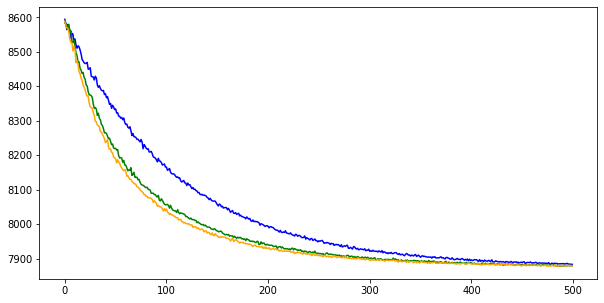

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(multinomial_ll_n_epochs.numpy(), color='blue')
ax.plot(reg_ll_n_epochs.numpy(), color='green')
ax.plot(corr_ll_n_epochs.numpy(), color='orange')
ax.hlines(-true_log_likelihood, 0, n_iter)
fig.savefig(os.path.join('./charts/', 'vrnn_loss_per_epoch.png'))


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.linspace(0, 30, len(multinomial_ll_total_time.numpy())), multinomial_ll_total_time.numpy(), color='blue')
ax.plot(np.linspace(0, 30, len(reg_ll_total_time.numpy())), reg_ll_total_time.numpy(), color='green')
ax.plot(np.linspace(0, 30, len(corr_ll_total_time.numpy())), corr_ll_total_time.numpy(), color='orange')
ax.hlines(-true_log_likelihood, 0, 30)
fig.savefig(os.path.join('./charts/', 'vrnn_loss_per_second.png'))


In [ ]:
reg_loss_df = pd.Series(reg_ll_per_seed.numpy())

In [ ]:
corr_loss_df = pd.Series(corr_ll_per_seed.numpy())

In [ ]:
multinomial_loss_df = pd.Series(multinomial_ll_per_seed.numpy())

In [ ]:
print(pd.concat([reg_loss_df, corr_loss_df, multinomial_loss_df], keys=['Regularized Transform', 'Variance Corrected Transform', 'Multinomial Resampling'], axis=1).describe().loc[['min', 'max', 'mean', 'std']].to_latex(float_format="%.3f"))

In [ ]:
reg_grad_df = pd.DataFrame(reg_grad_per_seed.numpy().std(0).reshape(-1, 3), columns = ['$\mu_t$', r'$\beta_t$', '$\ln(\sigma_t)$'])
corr_grad_df = pd.DataFrame(corr_grad_per_seed.numpy().std(0).reshape(-1, 3), columns = ['$\mu_t$', r'$\beta_t$', '$\ln(\sigma_t)$'])
multinomial_grad_df = pd.DataFrame(multinomial_grad_per_seed.numpy().std(0).reshape(-1, 3), columns = ['$\mu_t$', r'$\beta_t$', '$\ln(\sigma_t)$'])

In [ ]:
grad_df = pd.concat([reg_grad_df, corr_grad_df, multinomial_grad_df], keys=['Regularized Transform', 'Variance Corrected Transform', 'Multinomial Resampling'], axis=1)

In [ ]:
print(grad_df.describe().loc[['min', 'max', 'mean', 'std']].to_latex(float_format="%.3f"))

In [ ]:
grad_df.describe()